## LSTM for Predicting Volumetric Water Content (VWC)

This Jupyter notebook focuses on developing and training an LSTM model to predict volumetric water content (VWC) in the soil, a crucial indicator of soil moisture and plant stress, as part of a larger project on automated irrigation scheduling.

**Specifics:**

* **Model Development and Training:** The notebook builds, trains, and evaluates an LSTM model for VWC prediction, including functions for data preprocessing, sequence creation, model configuration, training, and validation.
* **Data Preprocessing and Feature Engineering:** It explores techniques like mean subtraction, derivative calculation, and log transformation to improve model performance by normalizing data, highlighting irrigation/precipitation events, and addressing data distribution issues.
* **Performance Evaluation and Challenges:** Time series cross-validation is used to assess modelgeneralizability, identifying challenges such as potential overfitting and difficulties in predicting mean VWC values.
* **Future Strategies:** The notebook suggests strategies to address these challenges, including expanding window cross-validation, introducing categorical features, and adjusting filter smoothing parameters.

**Contribution to the Project:**

This notebook serves as a crucial component of the larger automated irrigation scheduling project by:

* Providing a framework for developing and refining the machine learning model for VWC prediction.
* Identifying data preprocessing and feature engineering techniques that can improve model performance.
* Highlighting areas for further improvement and suggesting potential solutions.

The insights and results from this notebook will be used to:

* Build a more robust andgeneralizable model for predicting plant stress.
* Develop an algorithm to infer the optimal irrigation amount based on predicted VWC.
* Integrate the model with the LoRaWAN IoT platform for real-time data collection and irrigation control.

In summary, this notebook plays a vital role in developing and refining the machine learning component of the automated irrigation scheduling system, contributing to sustainable and efficient agricultural practices.

### Cell 1: Data Processing Functions

This cell defines functions for data preparation:

* **`trim_start_end_nans(df)`:** 
    * Removes rows with NaN values at the start and end of the DataFrame.
    * Iterates through each column and identifies the first and last valid indices.
    * Returns a trimmed DataFrame.

* **`process_data_for_plot(...)`:**
    * Processes data for a specific plot within a defined date range.
    * Key steps:
        * Connects to the database and loads data.
        * Filters data by plot number, date range, and relevant columns.
        * Encodes timestamps cyclically.
        * Eliminates duplicate indices and sets timestamp as index.
        * Handles missing values (trims NaNs and interpolates).
        * Smooths data in target columns using Savitzky-Golay filter.
        * Applies log transformation and creates binary column.
        * Returns processed DataFrame.

* **`transform_and_scale_data(...)`:**
    * Transforms and scales data for neural network input.
    * Key steps:
        * Copies DataFrame to avoid modifying original.
        * Subtracts mean from target columns.
        * Calculates difference-based derivatives for target columns.
        * Scales all columns using MinMaxScaler with a buffer.
        * Creates binary column.
        * Returns transformed and scaled DataFrame, updated scalers, and transformation metadata.

* **`reverse_transform_and_scale_data(...)`:**
    * Reverses transformations and scaling applied to the DataFrame.
    * Uses stored metadata to undo scaling, add back mean, and reconstruct original values from derivatives.

**Areas of Emphasis:**

* **Handling NaN values:** The code uses a combination of trimming and interpolation to handle missing data.
* **Data transformations:** The code applies Savitzky-Golay filter and log transformation to specific columns.
* **Scaling:** MinMaxScaler is used with a buffer to account for potential future data variations.

In [8]:

import sqlite3
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, target_columns, continuous_columns, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]
    
    # FILTER BY COLUMNS
    df = df[['TIMESTAMP'] + target_columns + continuous_columns]    

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)


    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[target_columns + continuous_columns].interpolate(method='pchip')
    
    # run savgol filter with no differentiation an window = 10 to target columns
    target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
    for column in target_columns:
        df[column] = savgol_filter(x=df[column], window_length=20, polyorder=4, deriv=0)
        
    # testing different transforms
    df['precip_irrig_log'] = np.log(df['precip_irrig'] + 1)
    

    return df

def subtract_mean(df, target_columns):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()  
        df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
            
            #  #Plot the original and derived columns
            # plt.figure(figsize=(10, 6))
            # plt.plot(df[col], label=col)
            # plt.plot(df[deriv_col_name], label=deriv_col_name)
            # plt.xlabel('Time')
            # plt.ylabel('Value')
            # plt.title(f'{col} vs {deriv_col_name}')
            # plt.legend()
            # plt.show()
            
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  
            

    return df, initial_values  # Return initial values as well

def scale_dataframe(df, scalers):
    """
    Optimally scale all columns in a DataFrame using MinMaxScaler, adjusting for an expanded range with a buffer. 
    This involves creating a dummy range for scaler fitting, then scaling the original data with the adjusted scaler.

    Args:
        df (pd.DataFrame): DataFrame with columns to be scaled.
        scalers (dict): Dictionary storing the scalers for each column.

    Returns:
        pd.DataFrame: Scaled DataFrame using the optimally adjusted scalers.
        dict: Dictionary of the adjusted scalers.
    """
    scaled_df = pd.DataFrame()  # Initialize an empty DataFrame for scaled values
    for column in df.columns:
        # Check if a scaler already exists; if not, proceed to create and fit a new one
        if column not in scalers:
            # Calculate the original range and apply a 30% buffer
            col_min, col_max = df[column].min(), df[column].max()
            range_buffer = (col_max - col_min) * 0.3  # 30% buffer
            buffered_min = col_min - range_buffer
            buffered_max = col_max + range_buffer

            # Create a new scaler and fit it on the buffered range
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler.fit([[buffered_min], [buffered_max]])
            scalers[column] = scaler

        # Scale the original data with the adjusted scaler
        scaled_values = scalers[column].transform(df[[column]].values.reshape(-1, 1)).flatten()  # Flatten the array here
        scaled_df[column] = scaled_values


    return scaled_df, scalers


def transform_and_scale_data(df, target_columns, scalers, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, returning the
    transformed DataFrame, updated scalers, and transformation metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        scalers (dict): Dictionary containing MinMaxScalers for each column, can be empty.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: Updated dictionary containing MinMaxScalers for each column.
        dict: A dictionary containing transformation metadata for the target columns.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    
    # Subtract mean from target columns
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns)
    
    # Apply transformations directly using helper functions
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Deleting or adjusting rows as necessary (e.g., due to NaN values from differentiation)
    df_transformed = df_transformed.iloc[1:]
    
    # Scale all columns in df_transformed
    df_transformed, scalers = scale_dataframe(df_transformed, scalers)
    
    #print(f"Shape of transformed DataFrame: {df_transformed.shape}")
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }
    
    # add 'precip_irrig_bool' as a binned column with 0 or 1
    df_transformed['precip_irrig_bool'] = df_transformed['precip_irrig_log'].apply(lambda x: 1 if x > 0 else 0)
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values,
        'columns': df.columns.tolist()
    }
    


    return df_transformed, transformation_metadata



def reverse_transform_and_scale_data(df, transformation_metadata, target_columns):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        target_columns (list): List of target columns to be reverse transformed and scaled.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    scalers = transformation_metadata['scalers']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    keep_original_cols = transformation_metadata['keep_original_cols']

    # #print dimensions of df
    #print(f"Shape of input DataFrame: {df.shape}")

    # Reverse scale the target columns
    for column in target_columns:
        if column in scalers:
            # Reshape data for inverse_transform
            scaled_data = df[[column]].values
            # Apply inverse_transform
            df[column] = scalers[column].inverse_transform(scaled_data)

    # Apply undifferencing with cumsum() 
    for column in target_columns:
        # Reverse subtract mean from target columns if they were mean-adjusted
        if column in mean_values:
            #print(f"Mean for {column}: ", mean_values[column])
            df[column] = df[column] + mean_values[column]
            #print(f"Reversed mean for {column}: ", df[column].head())


    return df


### Cell 2: Model Building and Training Functions

This cell defines functions for model building, training, and validation:

* **`create_sequences(...)`:**
    * Creates sequences of data for training the LSTM model using a sliding window approach.
    * Takes input and target data, window size, forecast horizon, and stride as parameters.
    * Returns sequences as NumPy arrays.

* **`build_model(...)`:**
    * Builds the LSTM model architecture with LSTM layers, BatchNormalization, Dropout, and a Dense output layer.
    * Compiles the model with Adam optimizer and MSE loss function.
    * Returns the compiled model.

* **`chronological_split(...)`:**
    * Splits data chronologically into training and validation sets based on the provided test_size proportion.

* **`scheduler(...)`:**
    * Defines a learning rate scheduler that reduces the learning rate exponentially after a certain number of epochs.

* **`train_step(...)`:**
    * Defines a single training step for the model using GradientTape to calculate gradients and update weights.
    * Updates learning rate based on the scheduler.

* **`val_step(...)`:**
    * Defines a single validation step, calculating the loss on validation data without updating weights.

* **`run_workflow(...)`:**
    * Orchestrates the training and validation process:
        * Iterates through each transformed DataFrame.
        * Creates sequences for each DataFrame.
        * Splits sequences chronologically into training and validation sets using TimeSeriesSplit.
        * Builds the LSTM model.
        * Trains the model for specified epochs, performing training and validation steps for each fold.
        * Implements early stopping and saves the best model.

**Areas of Emphasis:**

* **Model architecture:** The LSTM model uses multiple layers with decreasing units and regularization techniques.
* **Loss function:** MSE is used as the loss function to penalize prediction errors.
* **Validation strategy:** TimeSeriesSplit ensures chronological validation, preventing the model from learning from future data.
* **Early stopping:** The training process stops early if validation loss doesn't improve for a specified number of epochs.

In [9]:
import numpy as np
import pandas as pd
import pickle

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import keras
import json








# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)


def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.02)), 
        BatchNormalization(),
        Dropout(0.2),
        LSTM(128, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(32, return_sequences=False),
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model




def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val

# Learning Rate Scheduler function
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.0001)


# Define the training step
@tf.function(reduce_retracing=True)
def train_step(model, optimizer, loss_function, x_batch, y_batch, epoch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = loss_function(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Update the learning rate correctly using TensorFlow operations
    lr = scheduler(epoch, optimizer.learning_rate)
    optimizer.learning_rate.assign(lr)
    return loss

# Define the validation step
@tf.function(reduce_retracing=True)
def val_step(model, loss_function, x_batch, y_batch):
    predictions = model(x_batch, training=False)
    loss = loss_function(y_batch, predictions)
    return loss

def run_workflow(training_data_transformed, target_variables, input_window, forecast_horizon, stride, epochs, batch_size, patience, checkpoint_path):
    X_train_all, X_val_all, y_train_all, y_val_all = [], [], [], []
    dataframe_identifiers = []
    n_splits = 5  # Define the number of splits for cross-validation

    # Data preparation
    for i, transformed_data in enumerate(training_data_transformed()):
        df = transformed_data[0]
        X, y = create_sequences(df.values, df[target_variables].values, input_window, forecast_horizon, stride)
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        for fold, (train_index, val_index) in enumerate(tscv.split(X)):
            #print(f"Processing fold {fold+1}/{n_splits} for DataFrame_{i}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            X_train_all.append(X_train)
            X_val_all.append(X_val)
            y_train_all.append(y_train)
            y_val_all.append(y_val)
        
        dataframe_identifiers.append(f"DataFrame_{i}")

    # Model and training setup
    model = build_model((input_window, X_train_all[0].shape[2]), len(target_variables))
    initial_learning_rate = 0.001 
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    loss_function = tf.keras.losses.MeanSquaredError()
    best_val_loss = np.inf

    # Training and validation
    for epoch in range(epochs):
        #print(f"Epoch {epoch+1}/{epochs}")
        epoch_val_losses = []
        
        # Update learning rate using the scheduler function
        new_lr = scheduler(epoch, optimizer.learning_rate.numpy())
        optimizer.learning_rate.assign(new_lr)
        #print(f"Current learning rate: {optimizer.learning_rate.numpy()}")

        for fold in range(n_splits):
            #print(f"Training on fold {fold + 1}/{n_splits}")
            X_train, y_train = X_train_all[fold], y_train_all[fold]

            dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

            for x_batch, y_batch in dataset:
                train_step(model, optimizer, loss_function, x_batch, y_batch, epoch)

            # Validation
            X_val, y_val = X_val_all[fold], y_val_all[fold]
            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
            val_losses = []
            for x_batch, y_batch in val_dataset:
                val_loss = val_step(model, loss_function, x_batch, y_batch)
                val_losses.append(val_loss.numpy())

            avg_val_loss = np.mean(val_losses)
            epoch_val_losses.append(avg_val_loss)
            #print(f"Validation loss for fold {fold+1}/{n_splits}: {avg_val_loss}")

        # Average validation loss across folds
        average_val_loss = np.mean(epoch_val_losses)
        #print(f"Average validation loss for epoch {epoch+1}: {average_val_loss}")

        # Early stopping and model saving logic
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            model.save(checkpoint_path)
            #print(f"Model saved at epoch {epoch+1} with validation loss: {average_val_loss}")
            wait = 0  # Reset wait counter after improvement
        else:
            wait += 1
            if wait >= patience:
                #print(f"Stopping early due to no improvement in validation loss for {patience} epochs.")
                break

    return checkpoint_path, model







### Cell 3: Inference and Plotting

This cell defines functions for inference and plotting predictions:

* **`plot_predictions(...)`:**
    * Plots predicted and actual values for target columns of a specific plot.

* **`predict_with_sliding_window(...)`:**
    * Performs inference on new data using a sliding window approach.
    * Predicts target variables for each sequence using the trained model.
    * Reverses transformations and scaling.
    * Plots predictions and actuals for comparison.

**Areas of Emphasis:**

* **Sliding window inference:** The model predicts on sequences created by sliding a window across the new data.
* **Reverse transformation:** Predictions are transformed back to the original scale and format for interpretation.
* **Visualization:** Predictions and actuals are plotted for visual comparison and evaluation.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
    num_plots = len(target_columns)
    num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
    for i, column in enumerate(target_columns):
        plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
        plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
        plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
        plt.legend()
        plt.title(f'{column} for Plot {plot_number}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_with_sliding_window(model, df, current_transformation_metadata, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # first iteration flag
    first_iter = True

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))

        

        pred = model.predict(sequence)

        
        if first_iter:
            #print(f"Sequence shape: {sequence.shape}")
            # To #print the top 3 lines, slice the second dimension (sequence length)
            #print("Sequence (top 3 lines):")
           # #print(sequence[0, :3, :])  # Access the first element of the first dimension, then slice
            #print(f"Predicted shape: {pred.shape}")
            # Similarly, for the predictions, slice the second dimension
           #print("Predicted (top 3 lines):")
            #print(pred[0, :3, :])  # Access the first element of the first dimension, then slice
        
            first_iter = False


        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)

    # Apply reverse transformation and scaling to both predictions and actuals

    # Plot the predictions and actuals before reverse transformation and scaling
    #print("Plotting predictions and actuals before reverse transformation and scaling")
    #print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    #print(predictions_df.head(3))
    #print(actuals_df.head(3))

    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, current_transformation_metadata, target_columns)
    actuals_df = reverse_transform_and_scale_data(actuals_df, current_transformation_metadata, target_columns)

    # Example usage
    #print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    #print(predictions_df.head(3))
    #print(actuals_df.head(3))
    #print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    return predictions_df, actuals_df, timestamps

## Cell 4: Training and Inference Workflow

This cell demonstrates the complete workflow for training and evaluating an LSTM model on multiple dataframes, as well as performing inference on new data and visualizing the results. 

**1. Training:**

* **Dataframe Selection:** Specify the plot numbers for the dataframes you want to use for training. 
* **Variable Initialization:** Initialize scalers and define target columns, continuous columns, and training parameters (input window, forecast horizon, epochs, etc.).
* **Data Processing:** Use lambda functions or other methods to process and transform the dataframes consistently. 
* **Model Training:** Run the `run_workflow` function to train the model. This function should handle:
    * Data preparation
    * Model creation and training
    * Saving the best model and transformation metadata

**2. Inference:**

* **Model Loading:** Load the saved model for inference.
* **Data Preparation:** Process and transform the new data using the same methods and transformation metadata as the training data. 
* **Prediction:** Use the loaded model to make predictions on the transformed new data.
* **Reverse Transformation:** Transform the predictions back to the original scale and format using the saved transformation metadata.
* **Visualization:** Plot the predictions and actual values for comparison and evaluation. 

**Key Points:**

* **Consistency:** Ensure consistency in data processing and transformation between training and inference.
* **Parameter Tuning:** Adjust training parameters to optimize model performance.
* **Model and Metadata Saving:** Save the best model and transformation metadata for reliable inference.
* **Visualization:** Use plots to assess the quality of predictions and compare them to actual values. 

By following this workflow, you can effectively train an LSTM model and use it to make predictions on new data.

Training on plots [2009, 2004, 2007, 2001], testing on plot 2003
INFO:tensorflow:Assets written to: ./LSTM_dayhour\assets


INFO:tensorflow:Assets written to: ./LSTM_dayhour\assets


1/1 [==============================] - 0s 74ms/step


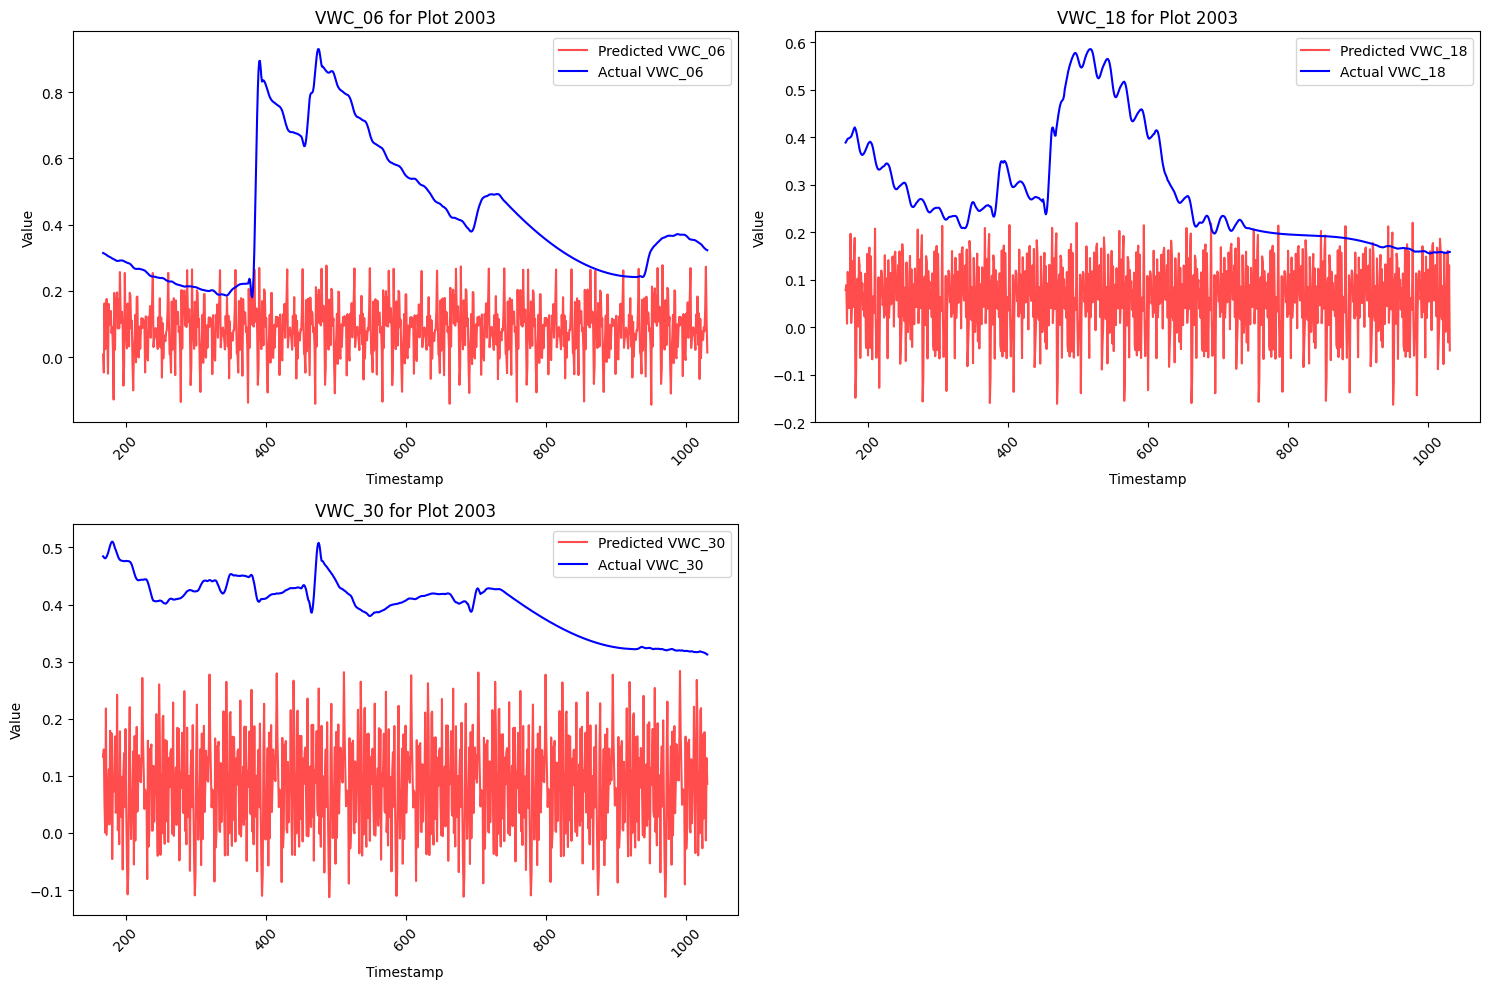

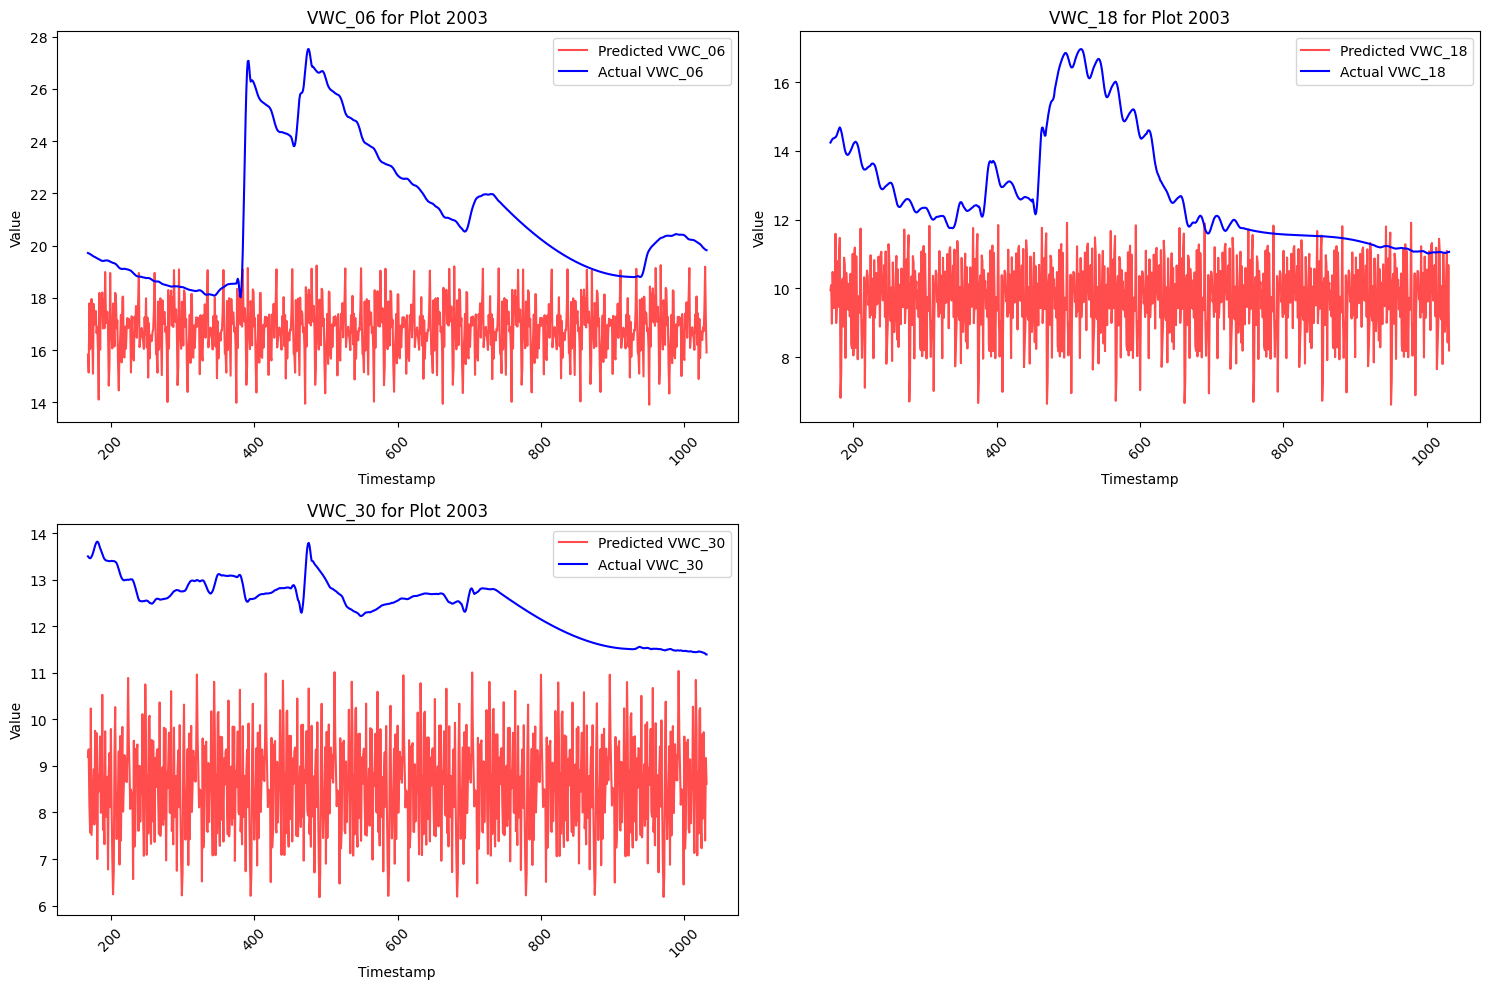

Training on plots [2009, 2004, 2007, 2001], testing on plot 2003


ValueError: in user code:

    File "C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_29268\4240082947.py", line 85, in train_step  *
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    File "c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1230, in apply_gradients  **
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\keras\src\optimizers\optimizer.py", line 638, in apply_gradients
        self.build(trainable_variables)
    File "c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\keras\src\optimizers\adam.py", line 143, in build
        self.add_variable_from_reference(
    File "c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\keras\src\optimizers\optimizer.py", line 1135, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\keras\src\optimizers\optimizer.py", line 513, in add_variable_from_reference
        variable = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [11]:
# Example Usage
#plot_numbers = [2014, 2015, 2007, 2013]
#plot_numbers = [2013, 2014, 2015, 2007]
#plot_numbers = [2014, 2013, 2015]
#plot_numbers = [2015, 2013, 2014]
plot_numbers = [2009, 2004, 2007, 2001, 2003]


# Initialize a scaler
scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'irrigation', 'precip_irrig', 'canopy_temp'
]
derivative_columns = ['precip_irrig']
input_window = 168
forecast_horizon = 96
stride = 1
epochs = 1
patience = 100
batch_size = 128
checkpoint_path = "./LSTM_dayhour"

# Set to True to keep original columns unchanged
keep_original_cols = True



def train_and_test_on_all_combinations(plot_numbers, target_columns, continuous_columns, time_columns, derivative_columns,
                                  input_window, forecast_horizon, stride, epochs, patience, batch_size, checkpoint_path,
                                  keep_original_cols):
    for i in range(len(plot_numbers)):
        train_plots = plot_numbers[:-1]
        test_plot = plot_numbers[-1]

        print(f"Training on plots {train_plots}, testing on plot {test_plot}")

        # Lambda function to handle training data and plot numbers
        training_data_dfs = lambda: [process_data_for_plot(plot, target_columns=target_columns, continuous_columns=continuous_columns) for plot in train_plots]

        # run once to get the transformation metadata
        _, transformation_metadata = transform_and_scale_data(training_data_dfs()[0], target_columns, scalers, keep_original_cols)
        
        # Create the checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_path, exist_ok=True)
        
        # Store the transformation metadata in checkpoint_path
        with open(f"{checkpoint_path}/transformation_metadata2.pkl", "wb") as file:
            pickle.dump(transformation_metadata, file)
        
        # re-run with the transformation metadata for all training dataframes
        training_data_transformed = lambda: [transform_and_scale_data(df, target_columns, transformation_metadata['scalers'], keep_original_cols) for df in training_data_dfs()]

        # Train the model
        checkpoint_path, model = run_workflow(training_data_transformed, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size, patience, checkpoint_path)

        # Prepare test data
        df_plot = process_data_for_plot(test_plot, target_columns, continuous_columns)

        # Drop VWC_42 column if it exists
        if 'VWC_42' in df_plot.columns:
            df_plot = df_plot.drop(columns=['VWC_42'])

        # Transform test data using existing transformation metadata
        df_plot, _ = transform_and_scale_data(df_plot, target_columns, transformation_metadata['scalers'], keep_original_cols)

        # Make predictions and store results
        predictions_df, actuals_df, timestamps = predict_with_sliding_window(
            model, df_plot, current_transformation_metadata=transformation_metadata,
            target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=test_plot
        )


# Run the training and testing loop
train_and_test_on_all_combinations(plot_numbers, target_columns, continuous_columns, time_columns, derivative_columns,
                                  input_window, forecast_horizon, stride, epochs, patience, batch_size, checkpoint_path,
                                  keep_original_cols)

Making predictions for plot 2014
1/1 [==============================] - 0s 17ms/step


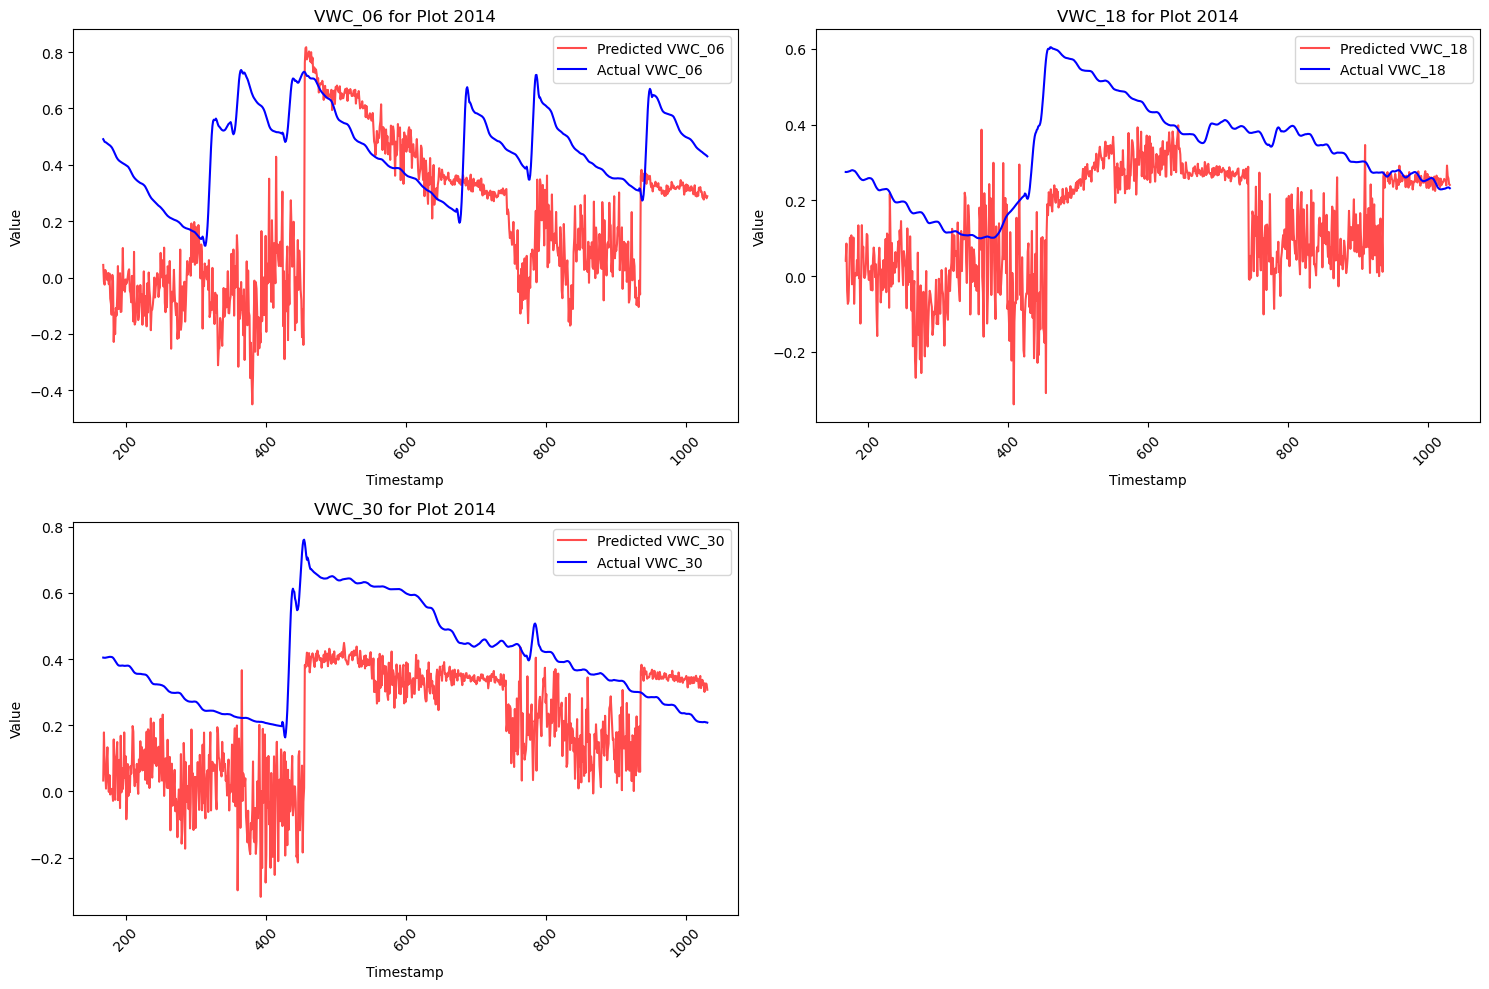

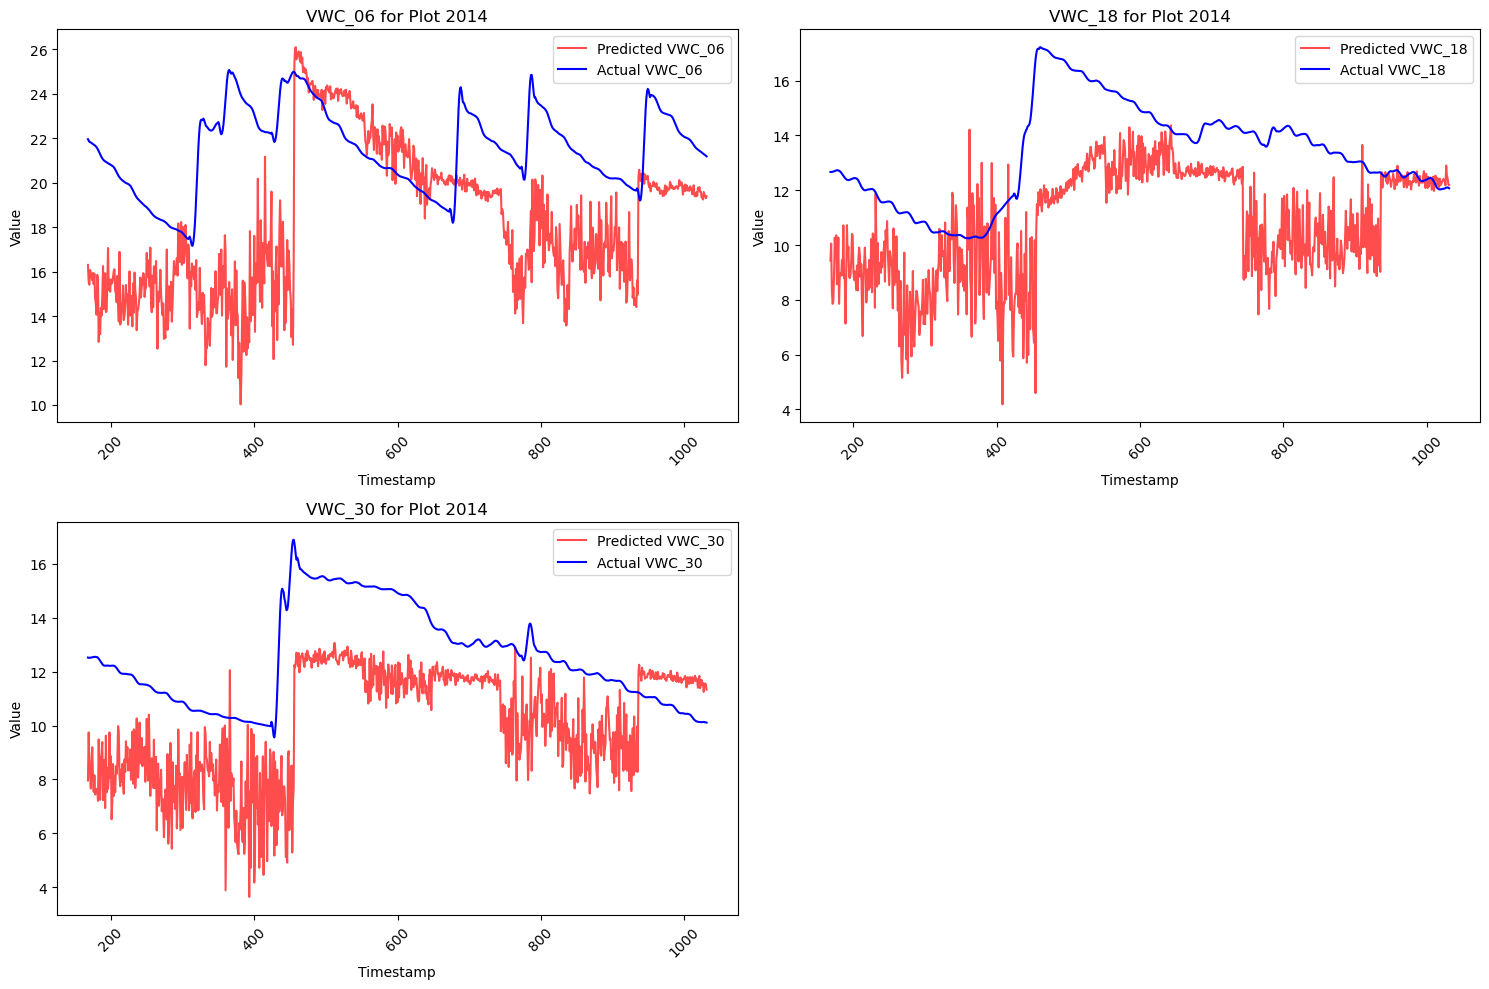

Making predictions for plot 2015
1/1 [==============================] - 0s 17ms/step


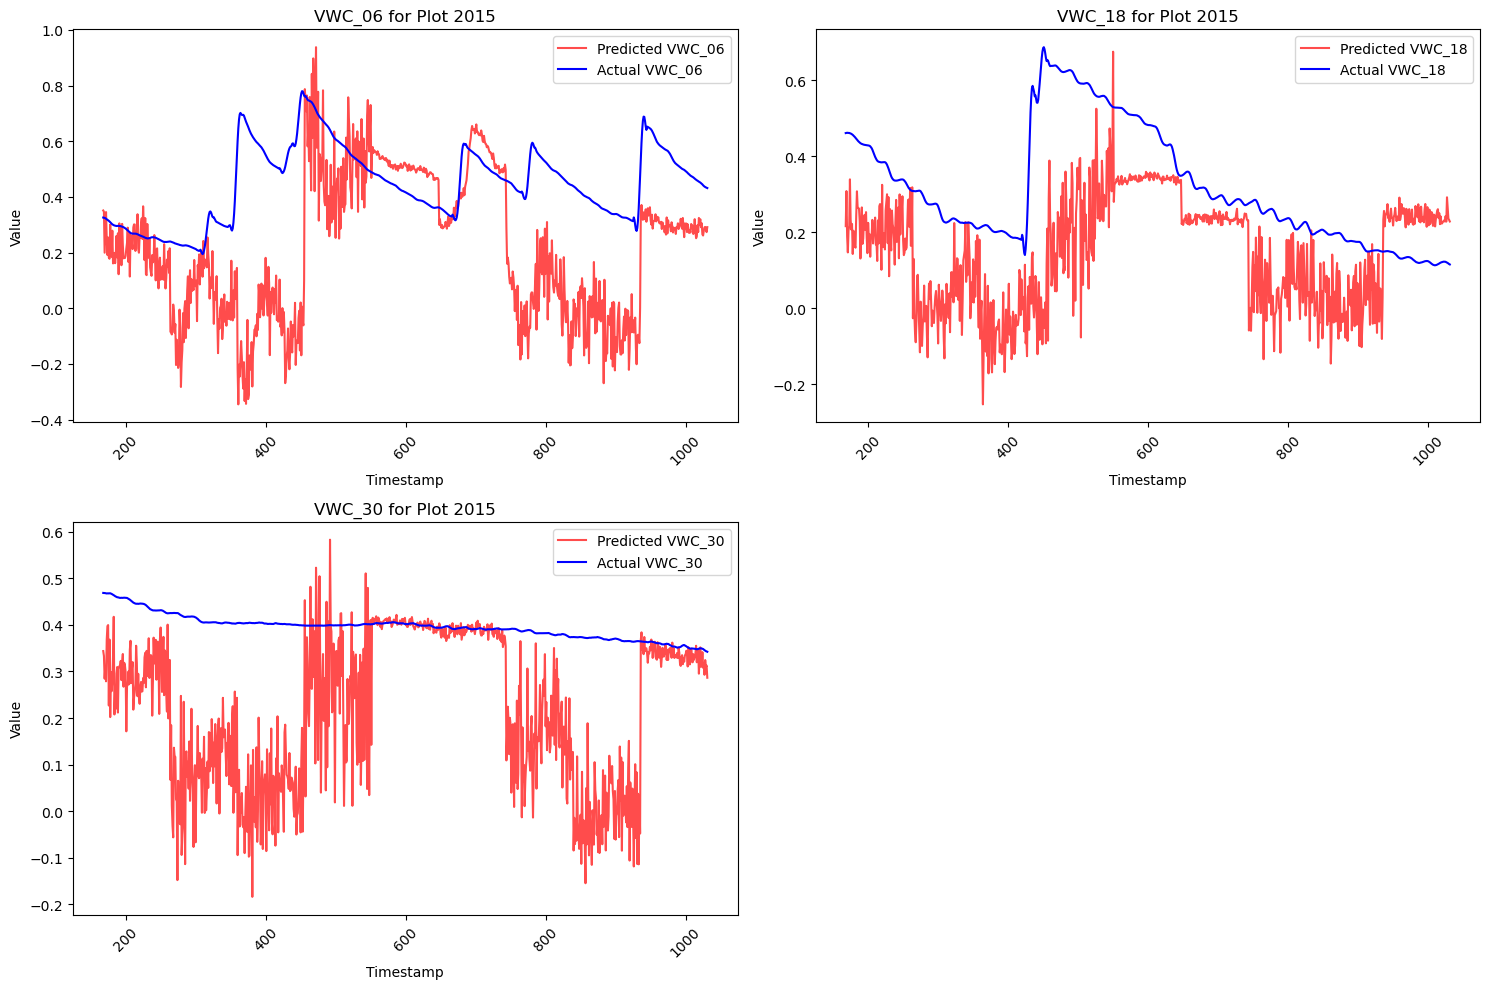

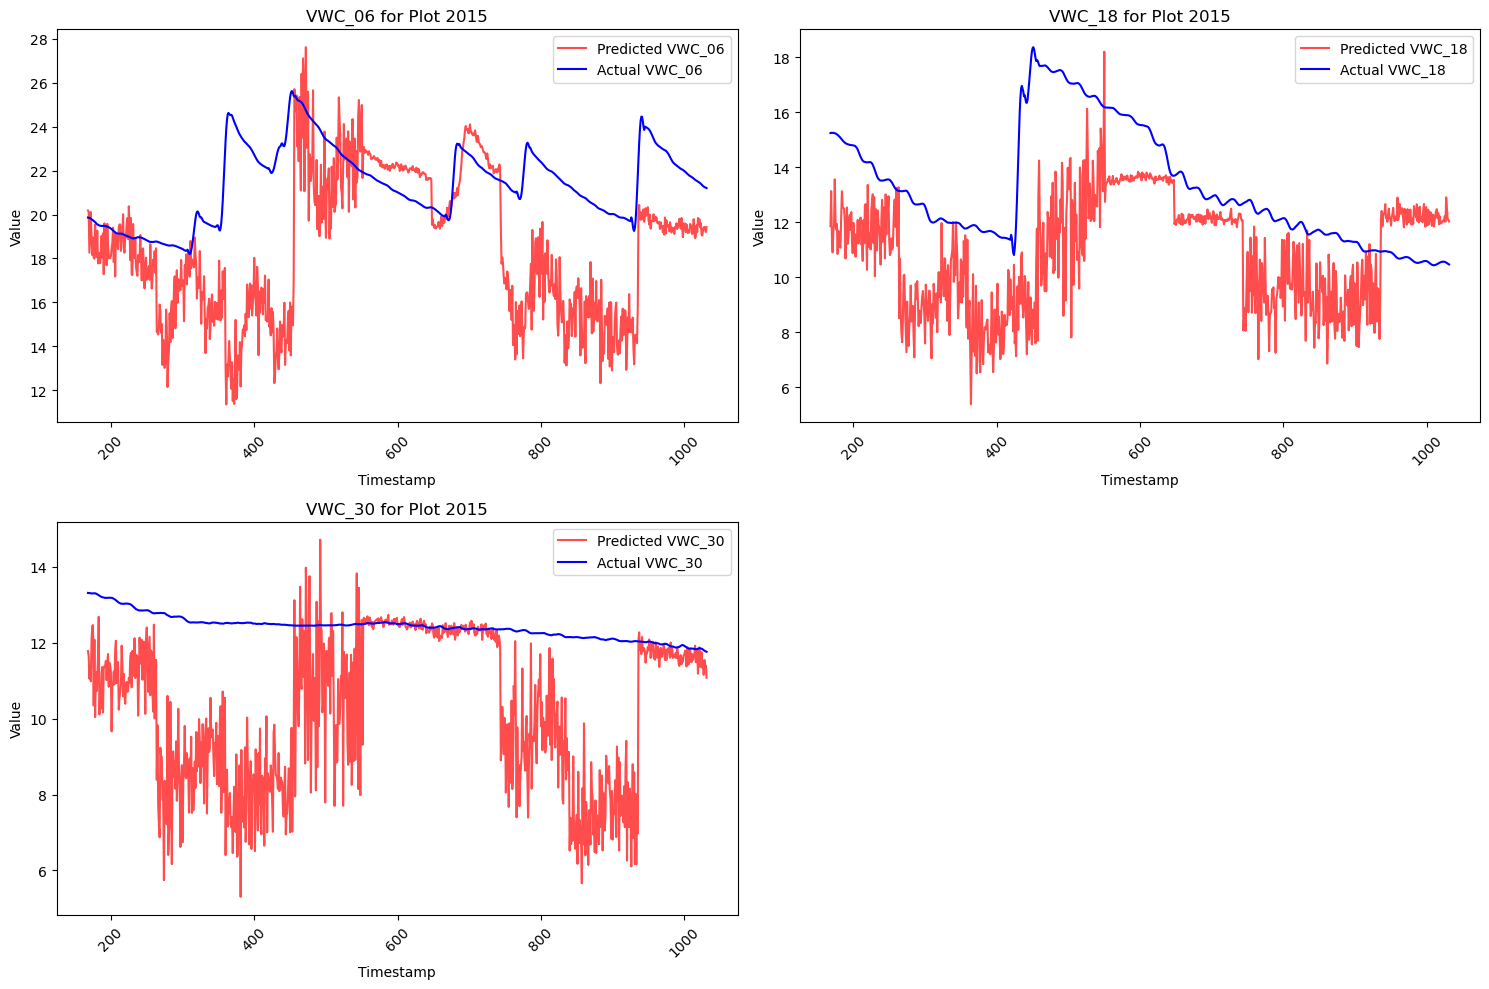

Making predictions for plot 2013
1/1 [==============================] - 0s 17ms/step


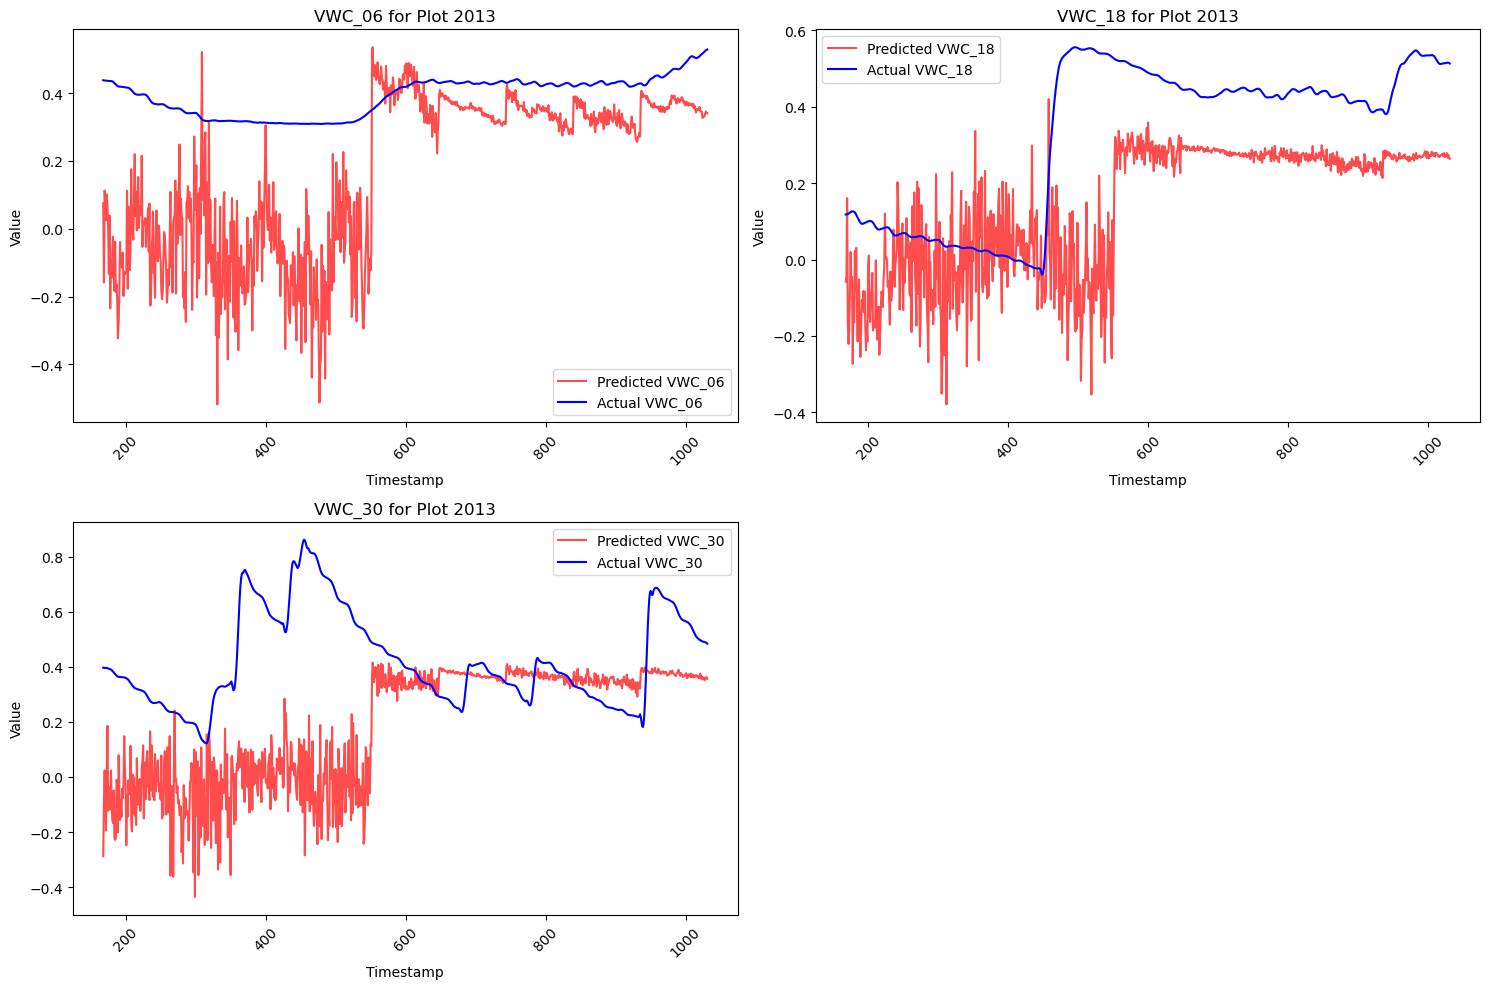

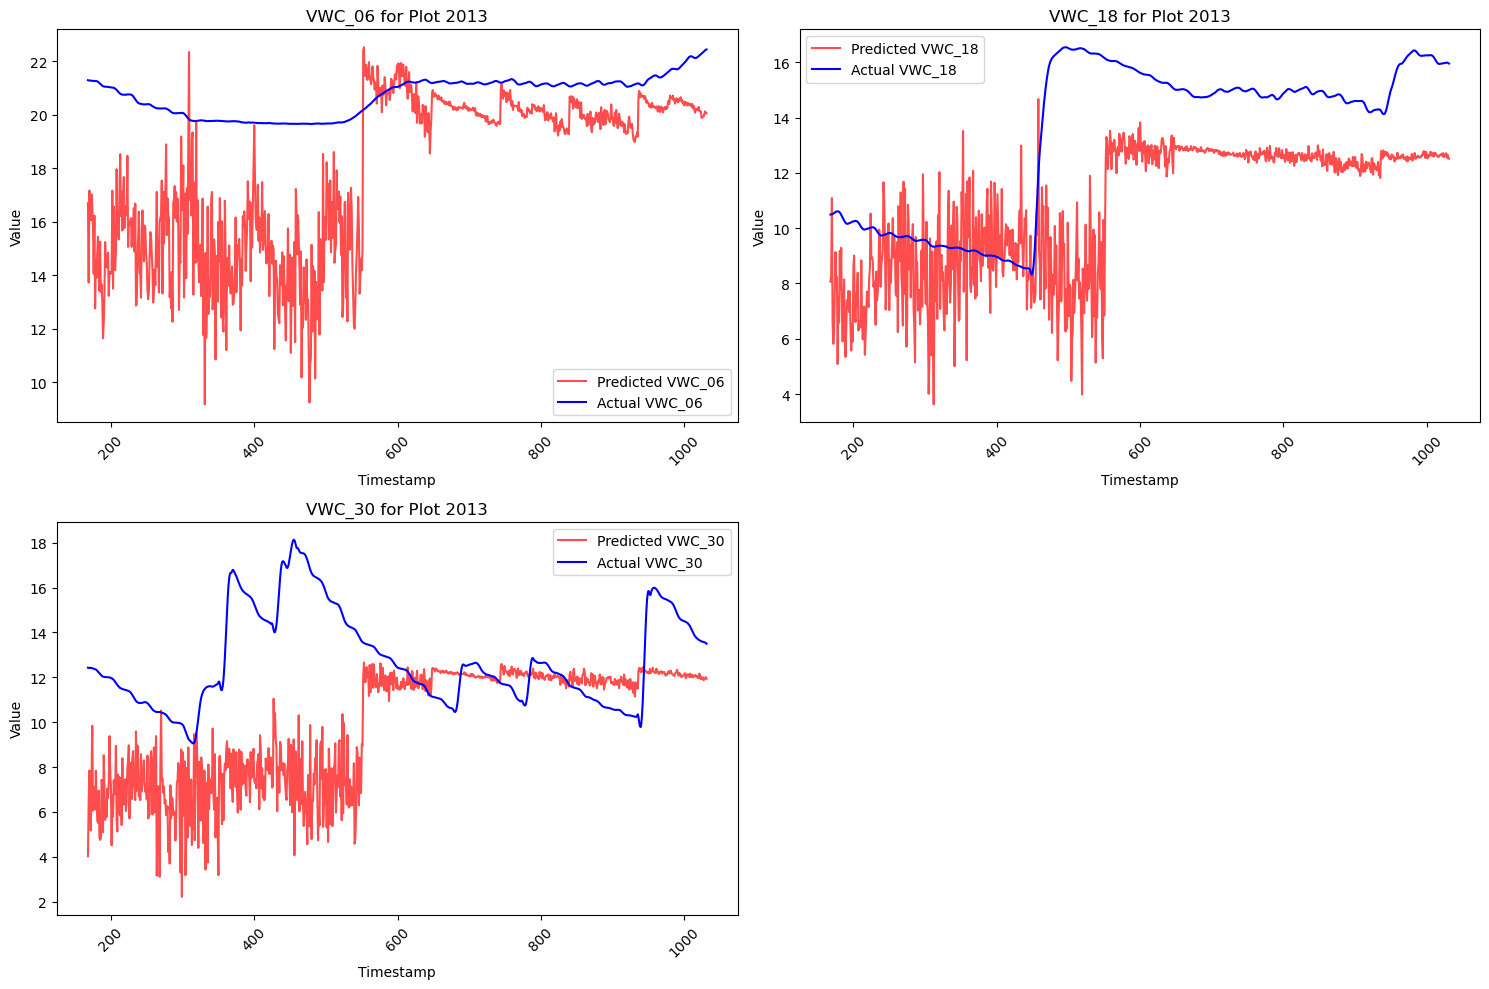

In [ ]:
def predict_on_plots(plot_numbers, target_columns, continuous_columns, checkpoint_path, keep_original_cols):
    # Load transformation metadata
    with open(f"{checkpoint_path}/transformation_metadata2.pkl", "rb") as file:
        transformation_metadata = pickle.load(file)

    # Load the model
    model = tf.keras.models.load_model(checkpoint_path)

    for test_plot in plot_numbers:
        print(f"Making predictions for plot {test_plot}")

        # Prepare test data
        df_plot = process_data_for_plot(test_plot, target_columns, continuous_columns)

        # Drop VWC_42 column if it exists
        if 'VWC_42' in df_plot.columns:
            df_plot = df_plot.drop(columns=['VWC_42'])

        # Transform test data using existing transformation metadata
        df_plot, _ = transform_and_scale_data(df_plot, target_columns, transformation_metadata['scalers'], keep_original_cols)

        # Make predictions and store results
        predictions_df, actuals_df, timestamps = predict_with_sliding_window(
            model, df_plot, current_transformation_metadata=transformation_metadata,
            target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=test_plot
        )


plot_numbers = [2014, 2015, 2013]

predict_on_plots(plot_numbers, target_columns, continuous_columns, checkpoint_path, keep_original_cols)

Making predictions for plot 2014
1/1 [==============================] - 0s 16ms/step


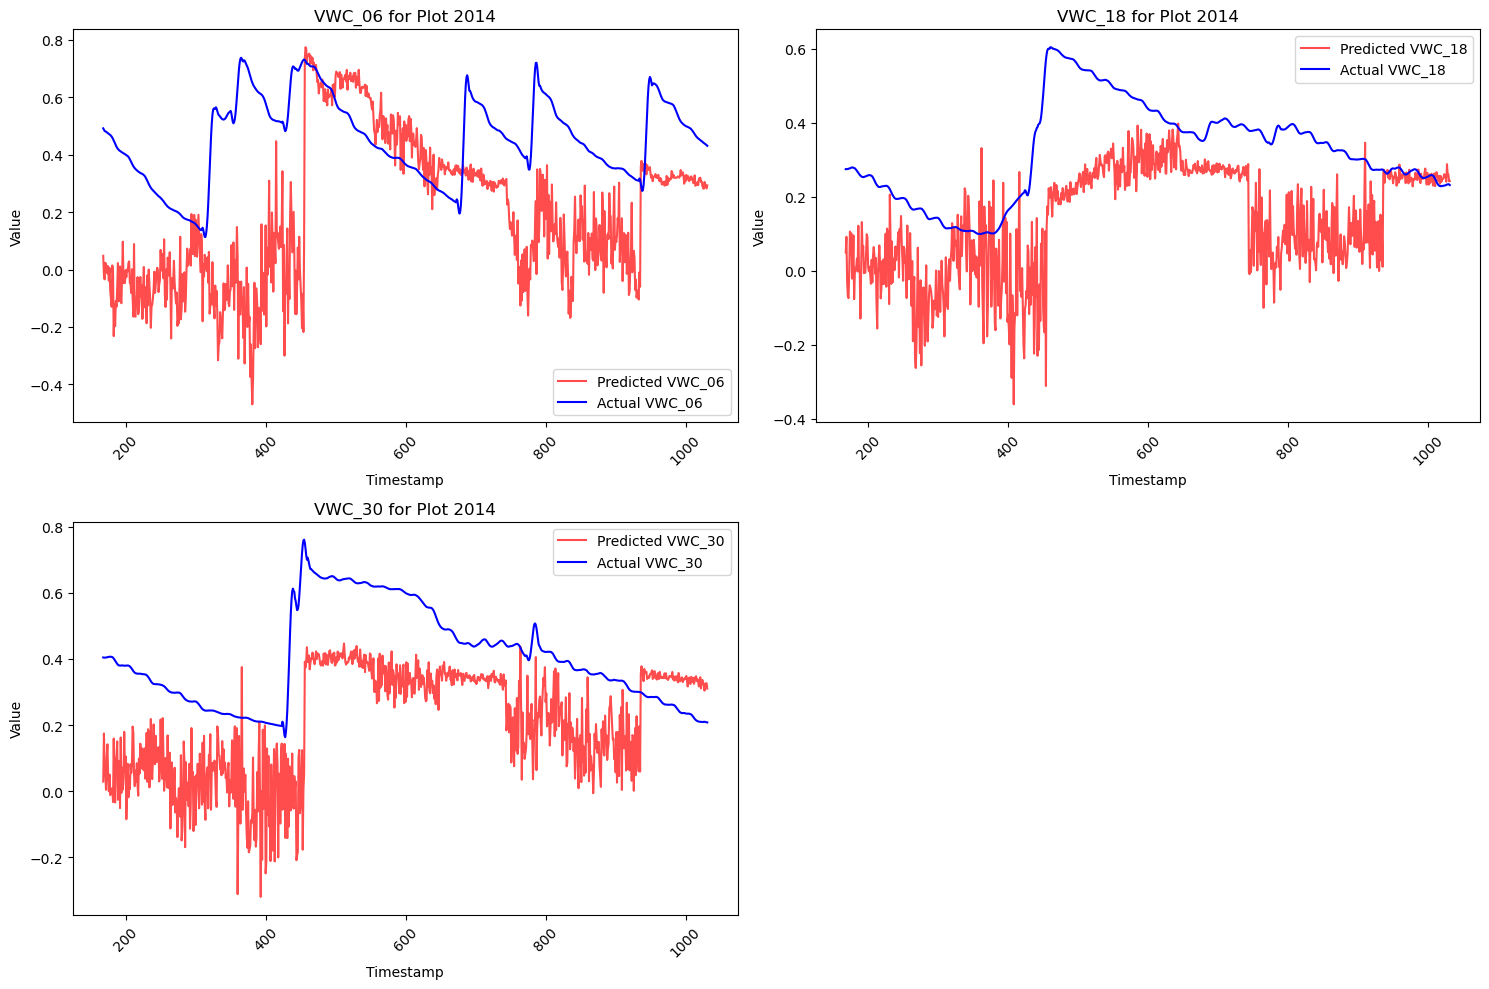

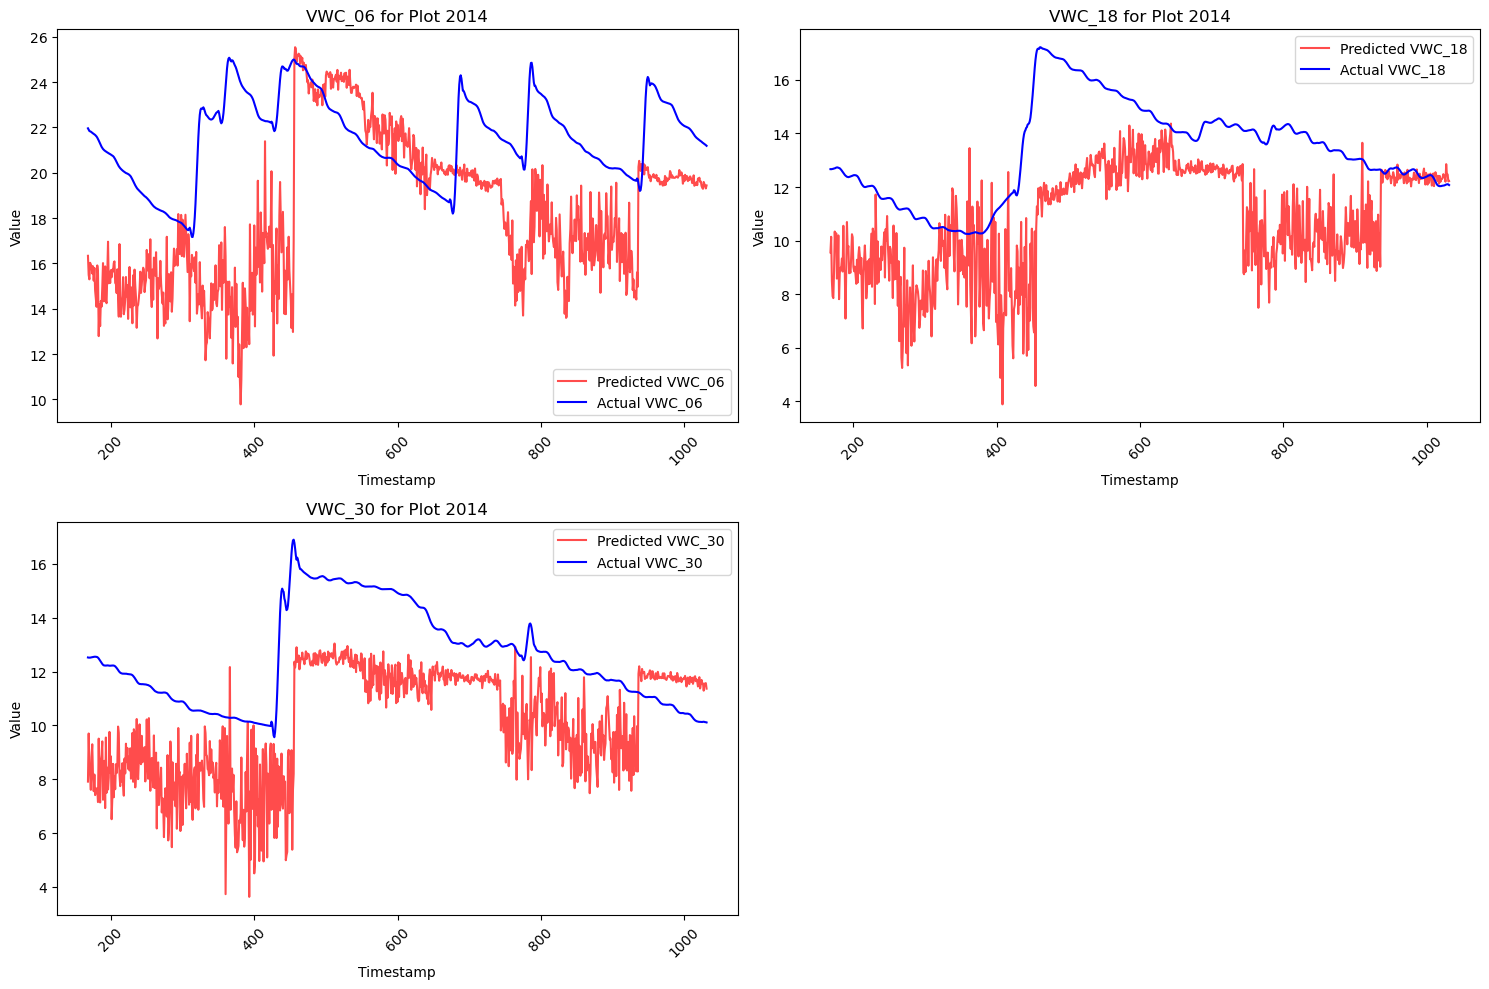

Making predictions for plot 2015
1/1 [==============================] - 0s 16ms/step


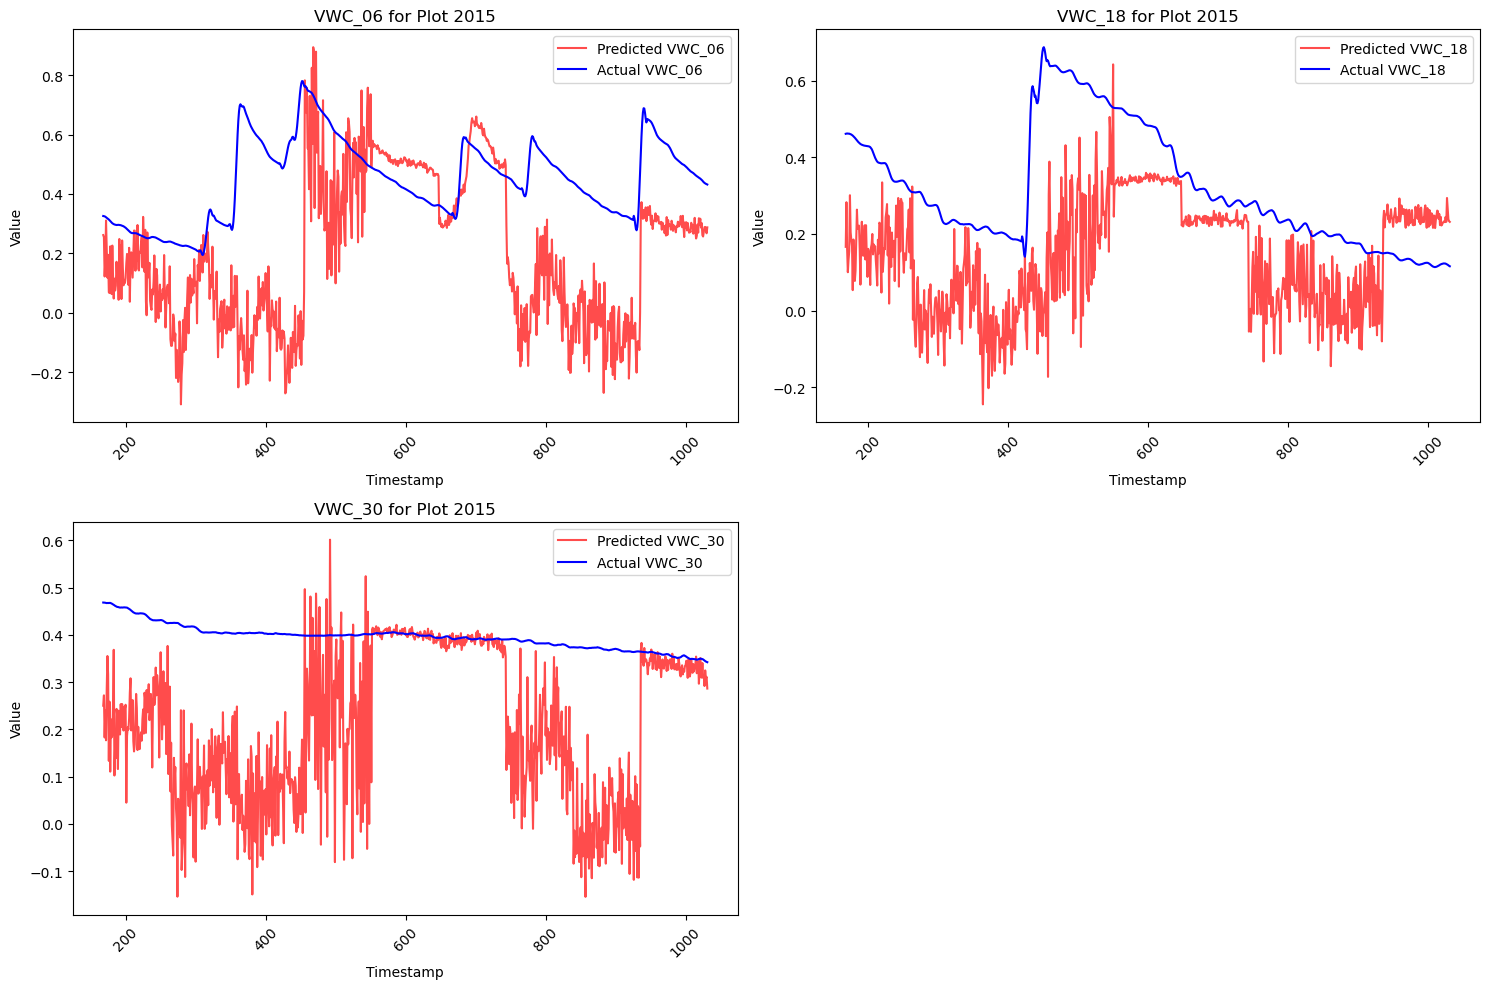

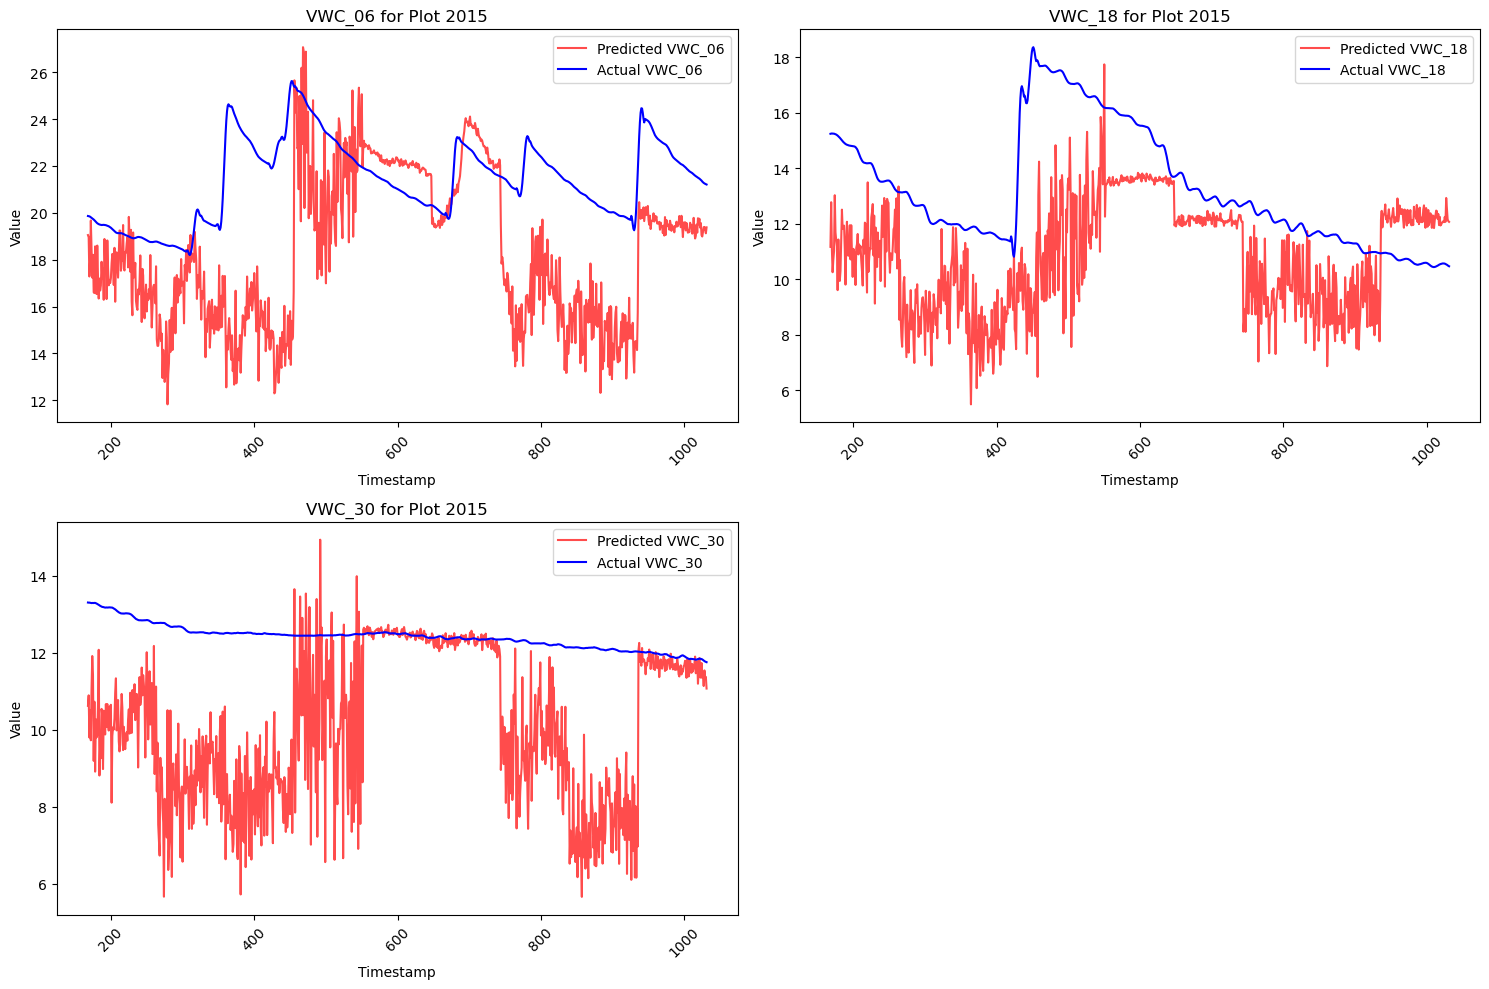

Making predictions for plot 2013
1/1 [==============================] - 0s 16ms/step


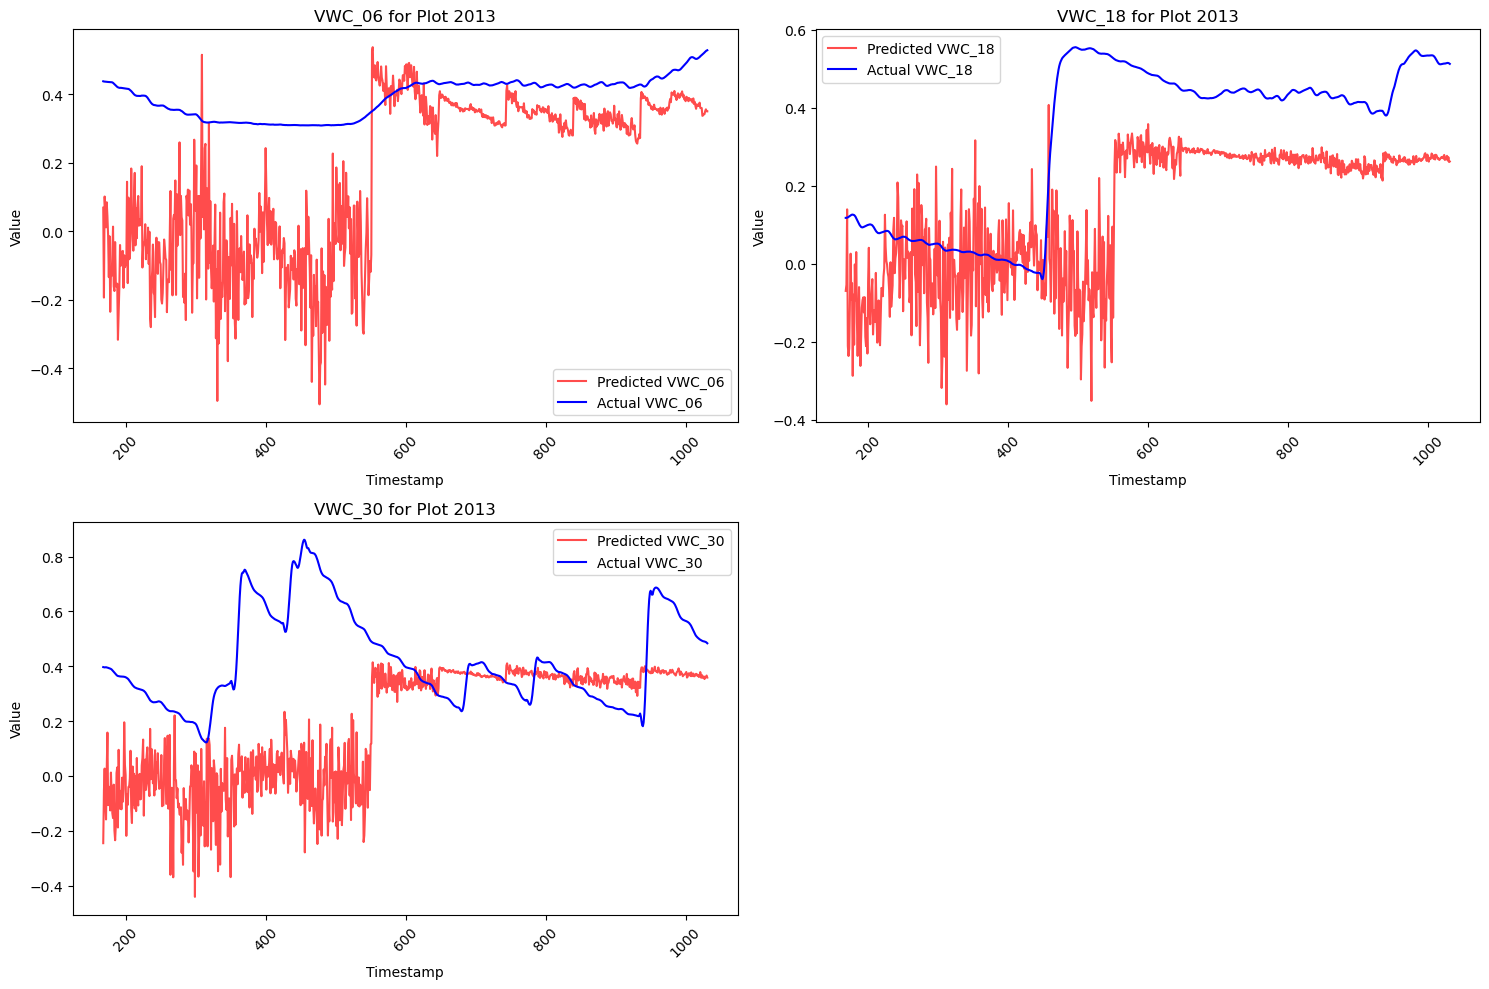

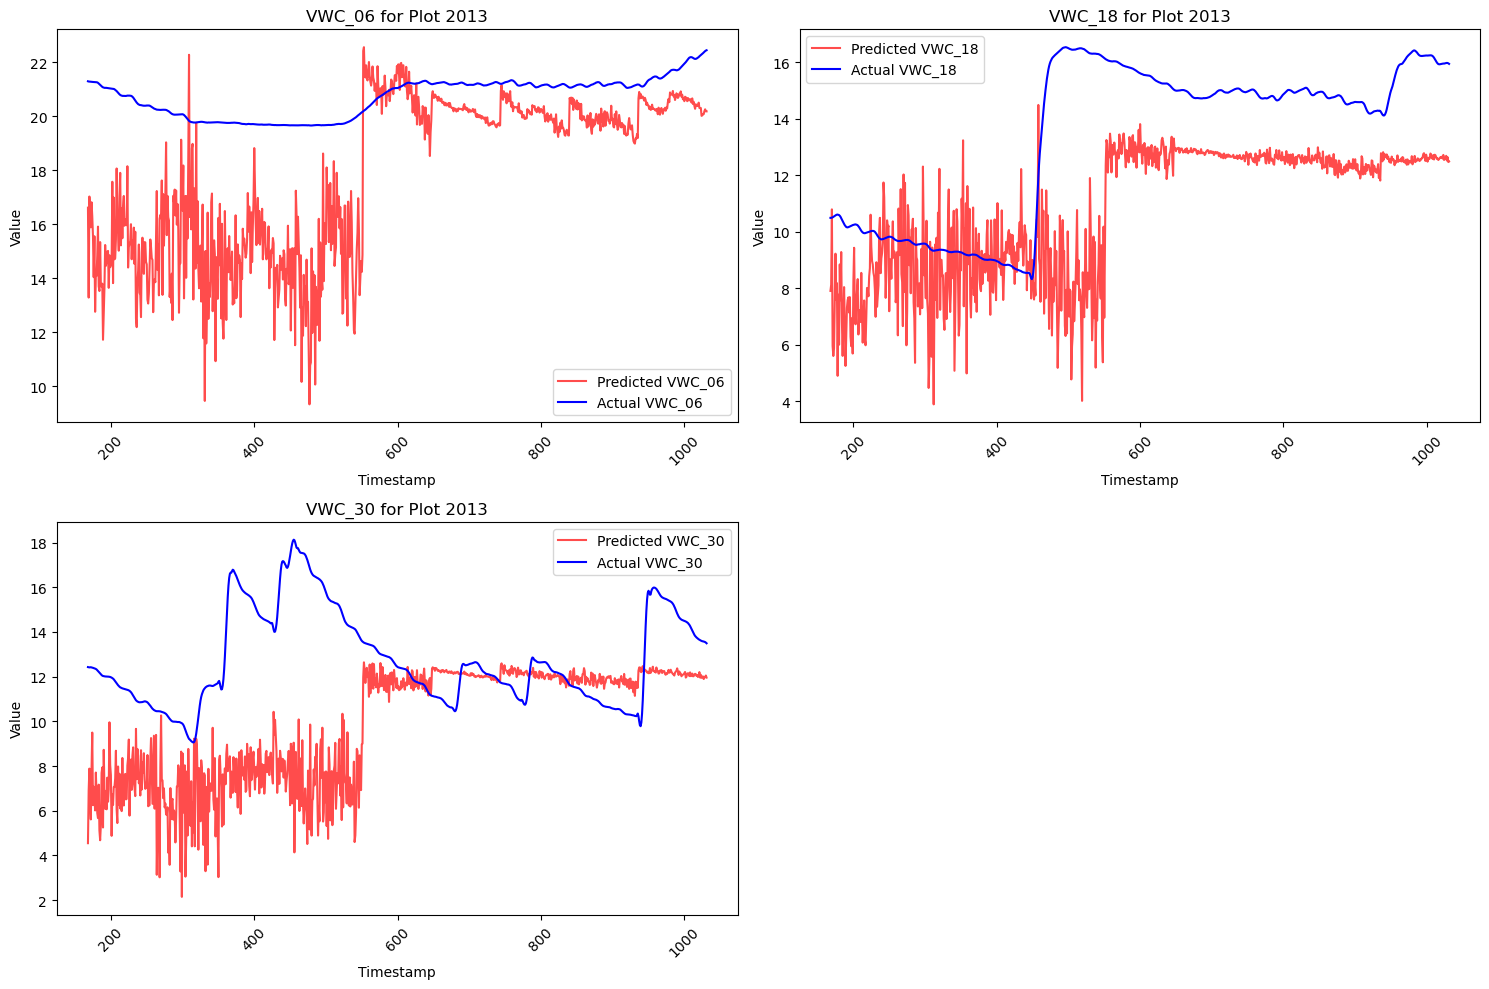

In [ ]:
def predict_on_plots(plot_numbers, target_columns, continuous_columns, checkpoint_path, keep_original_cols):
    # Load transformation metadata
    with open(f"{checkpoint_path}/transformation_metadata2.pkl", "rb") as file:
        transformation_metadata = pickle.load(file)

    # Load the model
    model = tf.keras.models.load_model(checkpoint_path)

    for test_plot in plot_numbers:
        print(f"Making predictions for plot {test_plot}")

        # Prepare test data
        df_plot = process_data_for_plot(test_plot, target_columns, continuous_columns)


        # Drop VWC_42 column if it exists
        if 'VWC_42' in df_plot.columns:
            df_plot = df_plot.drop(columns=['VWC_42'])

        # Transform test data using existing transformation metadata
        df_plot, _ = transform_and_scale_data(df_plot, target_columns, transformation_metadata['scalers'], keep_original_cols)

        # Make predictions and store results
        predictions_df, actuals_df, timestamps = predict_with_sliding_window(
            model, df_plot, current_transformation_metadata=transformation_metadata,
            target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=test_plot
        )


plot_numbers = [2014, 2015, 2013]

predict_on_plots(plot_numbers, target_columns, continuous_columns, checkpoint_path, keep_original_cols)